# Quantum circuits and simulation of noisy algorithms

Welcome to this hands-on session. The session is build around interactive Notebooks, that include code, explanations and tasks. Please run the code cells on your computer and follow the instructions of the tasks to deepen your learning.    

Jami Rönkkö, IQM Quantum Computers, email: jami@meetiqm.com

# Noisy simulation
In this notebook you learn:
- what is noise in context of quantum computing
- how the most basic noise mechanisms affect qubits
- to simulate execution of circuits on a noisy qpu with a simple noise model

Ideally, qubits consist of two isolated states. It is this isolation that gives rise to quantum effects. In reality, physical qubits cannot be perfectly isolated and **interact with their environment**. The environment consists of surrounding electromagnetic field, heat vibrations and particles with which the qubits interact (for example exchange energy).

Until large scale *error correction* is reached, the algorithms of today must be able to remain functional in the presence of noise. This makes testing algorithms under noise an important step for checking their susceptibility for noise and for designing various *error mitigation* techniques. 

## Energy relaxation and dephasing

Qubits are usually physically implemented in two-level system with ∣0⟩ as the ground state as and ∣1⟩ as the first excited state. For example in superconducting quantum computers, the qubits are often oscillator-type circuit elements called *transmons*. In transmons high frequency oscillation mode corresponds to ∣1⟩ and low frequency mode to ∣0⟩.  

 The typical basic environmental noise model for qubits takes two physical effects into account:
 1) Emission of energy from the qubit's excited state ∣1⟩ to its environment 
 2) Changes in the energy associated with the qubit's ∣1⟩ state

 These effects lead to what is called *energy relaxation* or *amplitude damping* and *dephasing* or *phase damping*. They can be neatly visualised with the Bloch sphere: 
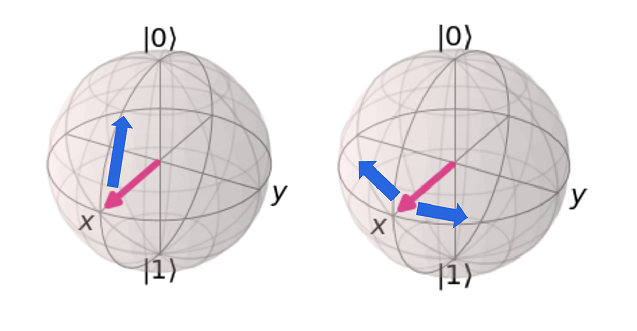

The left Bloch sphere implies that energy relaxation moves the qubit state towards ∣0⟩. As time goes on it becomes more and more likely that the qubit has emitted energy and relaxed to its ground state ∣0⟩. 

The right Bloch sphere shows the effect of *pure dephasing*: the phase of the qubit changes as a consequence of deviations in the energy of qubit's ∣1⟩ state, which could be caused e.g. changing magnetic fields traversing the qubit.

The strength of these effects is denoted by time parameters $T_{1}$ and $T_{2}$. The characteristic longitudinal relaxation time $T_{1}$ tells after what time qubit's amplitude information is considerably lost. Similarly, the characteristic transverse relaxation time $T_{2}$ signifies typical time it takes qubit to lose its phase information.

Note that energy relaxation also contributes to shortening of $T_2$, since it causes the qubit state to no longer point along same direction in X-Y plane of the Bloch sphere.

> **Technical note:** 
>
> Simulating noisy quantum circuits is way more resource demanding than ideal, noiseless circuits. 
>
> In the formalism of quantum mechanics state of a closed quantum system is described by a statevector. System of $n$ qubits have statevector of size $2^n$.
>
> However, *open quantum systems*, that interact with their environment, are described by *density matrices*, which have dimension $n^2 \times n^2 $ for $n$ qubits. 
>
> In qiskit this changing of formalism happens under the hood when user includes nouise. The user just need to be aware that noisy simulations will not be by default possible for more than say 10 qubits.   

In [ ]:
# Import everything from qiskit 
from qiskit import *
import numpy as np

<font color='#5ACA97'><h2>TASK 1</h2></font>
> In this notebook we will compare ideal and noisy execution of the Quantum Phase Estimation circuit. Run the following code snippets to create again the Quantum Phase Estimation circuit and Helmi QPU's hardware specifications. Transpile the QPE circuit and execute it with the noiseless `qasm_simulator`.
>
> a) Verify that the measurement outcome after transpilation is still  is $100$
>
> b) Looking at the original QPE circuit and Helmi's qubit connectivity, think what makes QPE quite *hardware efficient* on Helmi
>
> c) Include optimization to the transpilation by increasing `optimization_level` to 3. How much did the two-qubit gate count of the transpiled circuit decrease due to optimization? 
 

### Quantum Phase Estimation Algorithm
Let us recreate the QPE circuit for P($\pi/4$) gate here in compact form, so that we can use it later for noisy simulation.

In [ ]:
# Preparing the counting qubits in |+++> and target qubit in |1>
QPE_circuit = QuantumCircuit(4, 3)
QPE_circuit.x(3)
QPE_circuit.h([0,1,2])

# Controlled P gates
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        QPE_circuit.cp(np.pi/4, counting_qubit, 3)
    repetitions *= 2

# Function that applies n qubit QFT to a circuit
def QFT(circuit, n):
    for i in range(n):
        circuit.h(i)
        for j in range(i+1, n):               
            circuit.cp(np.pi / 2**(j-i), i, j)
    return circuit

# Function that applies inverse n qubit QFT to a circuit
def inverse_QFT(circuit, n):
    qft_circuit = QFT(QuantumCircuit(n, name='QFT'), n)
    inverse_qft_circuit = qft_circuit.inverse()
    circuit.append(inverse_qft_circuit.decompose(), circuit.qubits[:n])
    return circuit

# Apply inverse QFT and measurements on the counting qubits
QPE_circuit = inverse_QFT(QPE_circuit, 3)
QPE_circuit.measure([0,1,2], [0,1,2])

QPE_circuit.draw(output='mpl')

### Noiseless simulation of Helmi

In [ ]:
# Define a list of coupled qubits in Helmi
coupling_map = [[0, 2], [2, 0],             # each qubit in a connected pair can be either control or target of a two-qubit gate 
                [1, 2], [2, 1],
                [3, 2], [2, 3],
                [4, 2], [2,4]]  
                 
# Define gates that the QPU can execute 
basis_gates = ['r', 'cz']

# Transpile the QPE circuit to an equivalent circuit compliant with Helmi topology and gate set
transpiled_circuit = transpile(QPE_circuit, basis_gates = basis_gates, coupling_map = coupling_map, optimization_level=0)

transpiled_circuit.draw(output='mpl')

In [ ]:
# View the result of transpilation
print(f'Transpiled QPE circuit')
print(f'Depth: {transpiled_circuit.depth()}')
print(f'Gate counts: {transpiled_circuit.count_ops()}')

In [ ]:
# Execute the circuit on noiseless simulator
simulator = Aer.get_backend("qasm_simulator")
result = execute(transpiled_circuit, backend = simulator, shots = 1000).result()

state = result.get_counts()

from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts())

<font color='#5ACA97'><h2>TASK 2</h2></font>
> Below we create a simple example noise model. Read through the cells to see how this is done in `qiskit`. Don't hesitate to ask questions. You will get to compare ideal and noisy simulations after this.

# Creating a noise model
Let us create a simple example noise model, with **energy relaxation** and **dephasing**. The model is such that after every gate, both energy relaxation and dephasing operations are applied on the qubit. The strength of these operations depends on the ratio of gate duration and $T_1$ or $T_2$. This means that fast gates and low number of gates in the circuit translates to lesser detrimental effect from the noise.

In addition to $T_1$ and $T_2$ noise, we will also include **measurement errors**. This error accounts for the fact that the readout of quantum state is not perfect in reality. Qubit in state ∣0⟩ can be mistakenly measured as being in state ∣1⟩ and vice versa.

First, we define the parameters characterising our QPU in this example.

#### Device parameters:



In [ ]:
# Duration of the native gates in nano seconds 
r_duration = 40
cz_duration = 90

# Characteristic time scale for qubits' energy relaxation in nano seconds
t1 = [40_000] * 5

# Characteristic time scale for qubits' loss of phase coherence (dephasing) in nano seconds
t2 = [40_000] * 5

# Probabilities that the measurement outcome is wrong
p0given1 = 0.01        # 1 is miss-assigned as 0 
p1given0 = 0.005       # 0 is miss-assigned as 1


Then we follow the qiskit workflow for creating noise model. For more in-depth information see: https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html

#### The noise model:

In [ ]:
# Import functionality from qiskit's noise simulation package: aer
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import ReadoutError
from qiskit.providers.aer.noise.errors import thermal_relaxation_error
from qiskit.providers.aer import AerSimulator

# Initialize a noise model with basis gates of Helmi
noise_model = noise.NoiseModel(basis_gates=basis_gates)
n_qubits = 5

# Add single-qubit gate errors to noise model
for i in range(n_qubits):                      #  We apply noise for each qubit separately, in this way different qubits could have different T1 and T2 or gate durations
    thermal_relaxation_channel = thermal_relaxation_error(t1[i], t2[i], r_duration)         # Qiskit calls amplitude and phase damping together "thermal_relaxation_error"
    noise_model.add_quantum_error(thermal_relaxation_channel, "r", [i])                     # We assign thermal_relaxation_error operation to be applied after each "r" gate


# Add two-qubit gate errors to noise model
# Same as above, but we have to do some extra coding to build the two-qubit noise operations
for i, connection in enumerate([[0,2],[1,2],[3,2],[4,2]]):
    first_qubit = connection[0]
    second_qubit = connection[1]

    thermal_relaxation_channel = thermal_relaxation_error(t1[first_qubit], t2[first_qubit], 
        cz_duration).tensor(thermal_relaxation_error(t1[second_qubit], t2[second_qubit], cz_duration))

    noise_model.add_quantum_error(thermal_relaxation_channel, "cz", [first_qubit, second_qubit])    # We assign thermal_relaxation_error operations to be applied after each "cz" gate 


# Add measurement errors
# The ReadoutError takes lists, that define the probability of measurement error occurring for one qubit
meas_errors = ReadoutError([[1 - p1given0, p1given0],       # First element is probability of measuring 0 as 0 (correct outcome). Second is measuring 0 as 1 (wrong outcome)
                            [p0given1, 1 - p0given1]])      # Similarly here; first probability of measuring 1 as 0 (wrong outcome) and then measuring 1 as 1 (correct outcome)


for i in range(n_qubits):                                  # Add measurement error to all qubits
    noise_model.add_readout_error(meas_errors, [i]) 

# We can print the noise model to see which instructions and qubits have noise
print(noise_model)

<font color='#5ACA97'><h2>TASK 3</h2></font>
> Once we have defined both the circuit and `noise_model`, we can execute noisy simulations. Run the code cell below to view outcome of a noisy simulation. Study the effect of noise to the measurement outcome by changing the device parameters in the topmost cell of this section and observe how the probability distribution changes when you:
>
> a) Decrease t1 time, what happens if you make t1 extremely short? (Note: t2 can newer be bigger than 2*t1, so you have the decrease t2 also here)
>
> b) Decrease t2 time, what happens if you make t2 extremely short? (while keeping t1 long)
>
> c) Increase the gate durations, what happens?
>
> d) Increase the probabilities for measurement errors, what happens? 
>
> You can also try changing the t1s and t2s individually for each qubit by giving different values in the parameter lists

### Noisy simulation of Helmi
Using the qiskit's `AerSimulator`, we can include both noise model and hardware specifications of our QPU in the simulator backend. Then running the `execute` function on our `QPE_circuit` will first do the transpilation to Helmi's connectivity and gate set and then run the noisy simulation based on our noise model.  

In [ ]:
noisy_simulator = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, basis_gates = basis_gates)

result = execute(QPE_circuit, backend = noisy_simulator, shots= 100_000, optimization_level=3).result()

plot_histogram(result.get_counts())

## Takeaway

- Quantum computers are susceptible for environmental noise which causes errors in the computations

- If one has thousands of qubits available, these errors can be dealt with quantum error correction

- Before that one has to try to mitigate errors with hardware and software improvements and tricks
 
- We have simulated QPE algorithm on the connectivity and gate set of Helmi QPU with a simple noise model


Thank you for attending the Hands-on session! You can send any questions to: jami@meetiqm.com